In [1]:
%load_ext autoreload
%autoreload 2

# Модель LGBM

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance

import lightgbm as lgb

import shap

import math

import os
import src

from dotenv import load_dotenv

In [3]:
pd.options.display.float_format = '{:,.2f}'.format

## Подготовка данных

In [4]:
load_dotenv(override=True)

WORK_DIR = os.getenv("DATA_DIR")
FILE_NAME = 'df_work_test.zip'

filepath = f'..\\{WORK_DIR}\\{FILE_NAME}'

df1 = pd.read_csv(filepath, index_col=0, parse_dates=True)

In [5]:
X = df1.drop(['Fe2+', 'ac'], axis=1)
X.reset_index(drop=True)
y = df1['Fe2+']
y.reset_index(drop=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [6]:
train_data = lgb.Dataset(X_train, y_train)
test_data = lgb.Dataset(X_test, y_test, reference=train_data)

## Тренировка модели

In [26]:
model = lgb.LGBMRegressor()

In [27]:
params = {'objective': "regression",
          'learning_rate': 0.1,
          'metric': 'rmse',
          # 'max_depth': 15,
          # 'num_leaves': 20,
          # 'feature_fraction': 0.8,
          # 'subsample': 0.2,
          'num_boost_round': 1000,
          'early_stopping_rounds': 30}

In [28]:
model = lgb.train(params, train_data,
                  valid_sets=[test_data],
                  valid_names=['test'])

Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005523 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12142
[LightGBM] [Info] Number of data points in the train set: 38041, number of used features: 48
[LightGBM] [Info] Start training from score 1.377328
[1]	test's rmse: 0.808235
Training until validation scores don't improve for 30 rounds
[2]	test's rmse: 0.782197
[3]	test's rmse: 0.76103
[4]	test's rmse: 0.742915
[5]	test's rmse: 0.729203
[6]	test's rmse: 0.71583
[7]	test's rmse: 0.7067
[8]	test's rmse: 0.697842
[9]	test's rmse: 0.689697
[10]	test's rmse: 0.683263
[11]	test's rmse: 0.677047
[12]	test's rmse: 0.672039
[13]	test's rmse: 0.666697
[14]	test's rmse: 0.662474
[15]	test's rmse: 0.659343
[16]	test's rmse: 0.656081
[17]	test's rmse: 0.652641
[18]	test's rmse: 0.647931
[19]	test's rmse: 0.645605
[20]	test's rmse: 0.643022
[2

Метрики качества
RMSE: 0.4866
MAE: 0.1680
R2: 0.6635


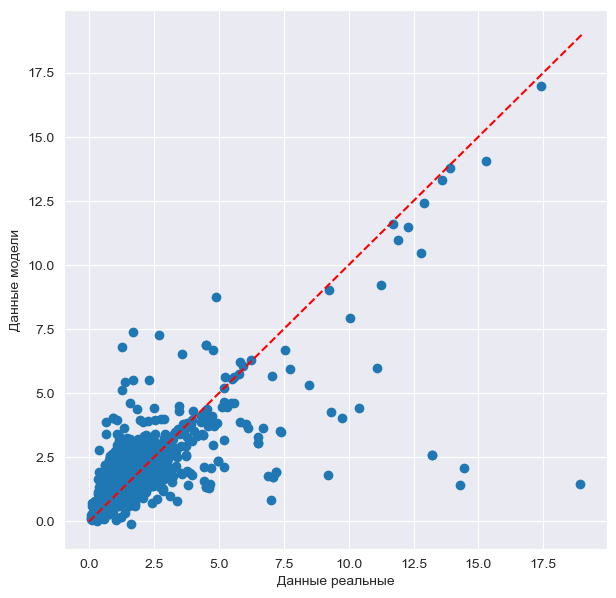

In [29]:
src.lib.model_score(model, X_test, y_test)

In [17]:
pred = model.predict(X_test)

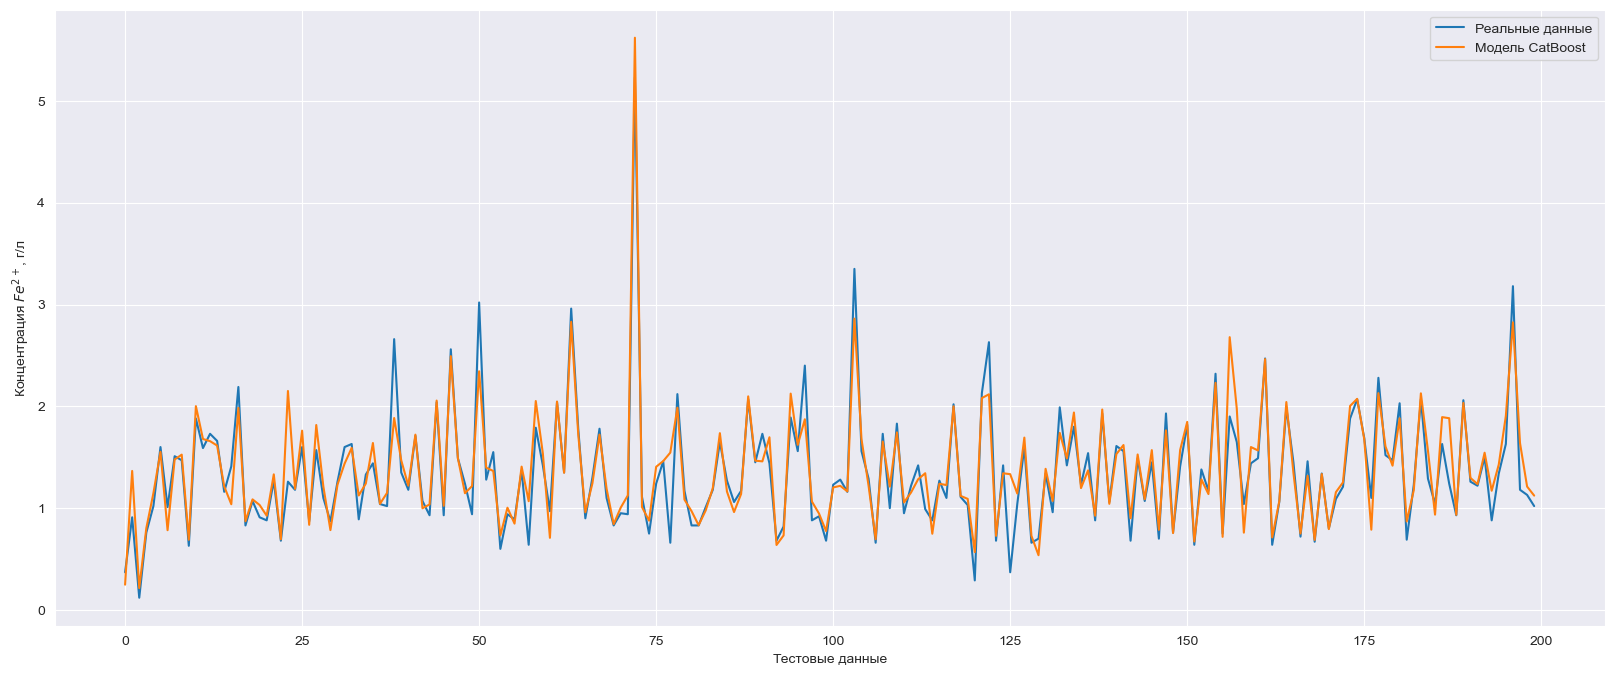

In [18]:
plt.figure(figsize=(20,8))

start = 0
end = 200

plt.plot(y_test.values[start:end], label='Реальные данные')
plt.plot(pred[start:end], label='Модель CatBoost')

plt.ylabel("Концентрация $Fe^{2+}$, г/л")
plt.xlabel('Тестовые данные')

plt.legend()
plt.show();

## Посмотрим наиболее важные признаки

In [30]:
# model.params["objective"] = "regression"

explainer = shap.Explainer(model)
shap_values = explainer(X_test)

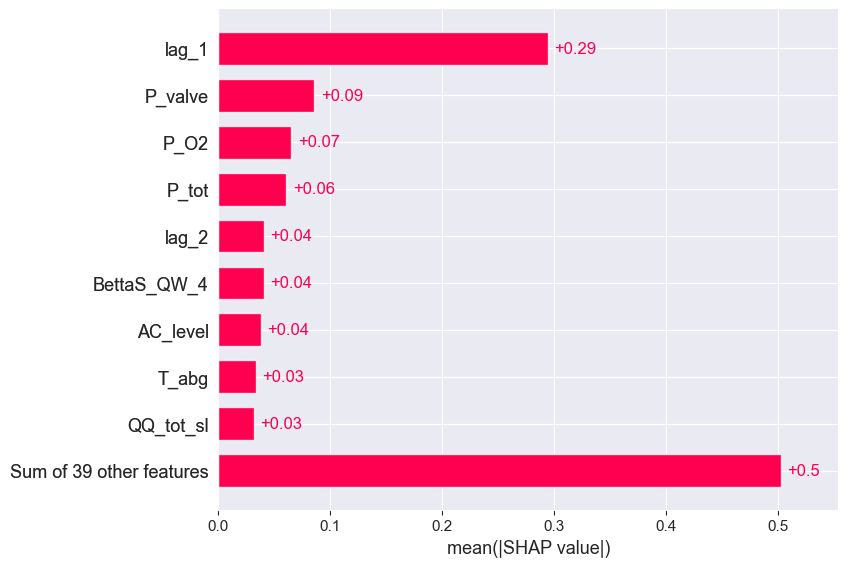

In [31]:
shap.plots.bar(shap_values)

## Сохранение модели

In [33]:
model.save_model('../models/model_lgbm', num_iteration=model.best_iteration)

Потом загрузка модели - model = lgb.LGBMRegressor(model_file='model_lgbm')